# Non-parametric Bayes: Gaussian Processes

Use of the term "non-parametric" in the context of Bayesian analysis is something of a misnomer. This is because the first and fundamental step in Bayesian modeling is to specify a *full probability model* for the problem at hand. It is rather difficult to explicitly state a full probability model without the use of probability functions, which are parametric. Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. In fact, Bayesian non-parametric models are *infinitely* parametric.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd 
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as tt
import matplotlib.pylab as plt
import matplotlib.cm as cmap
sns.set_context('notebook')
import warnings
warnings.filterwarnings("ignore", module="theano")
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")

np.random.seed(42)

## Building models with Gaussians

What if we chose to use Gaussian distributions to model our data? 

$$p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}$$

There would not seem to be an advantage to doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from  a multivariate normal distribution is also normal:

$$p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
  {\mu_x}  \\
  {\mu_y}  \\
\end{array}
}\right], \left[{
\begin{array}{c}
  {\Sigma_x} & {\Sigma_{xy}}  \\
  {\Sigma_{xy}^T} & {\Sigma_y}  \\
\end{array}
}\right]\right)$$

$$p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)$$

Also, conditionals distributions of a subset of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, any finite subset of which have a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a *function*. When we write a function that takes continuous values as inputs, we are essentially specifying an infinte vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a ***disribution over functions***. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a **mean function** and a **covariance function**:

$$p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))$$

It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed. 

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(x) &=0 \\
k(x,x^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to 1 and those that are far apart return values closer to zero. 

In [2]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

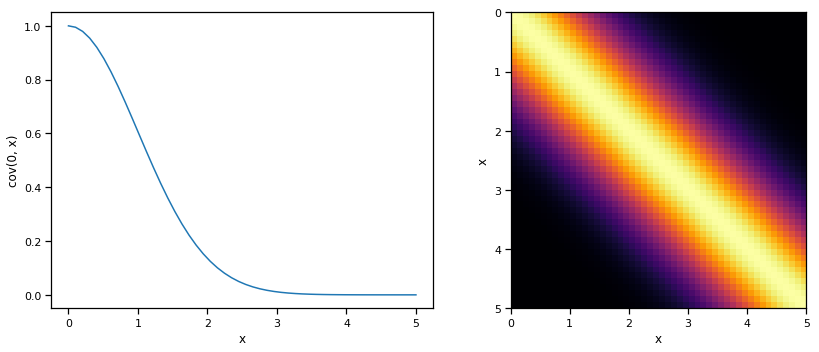

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xrange = np.linspace(0, 5)
ax1.plot(xrange, exponential_cov(0, xrange, [1, 1]))
ax1.set_xlabel('x')
ax1.set_ylabel('cov(0, x)')

z = np.array([exponential_cov(xrange, xprime, [1, 1]) for xprime in xrange])
ax2.imshow(z, cmap="inferno", 
       interpolation='none', 
       extent=(0, 5, 5, 0))
ax2.set_xlabel('x')
ax2.set_ylabel('x')

plt.tight_layout();

It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process -- surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its parameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function evaluated at those points.

## Sampling from a Gaussian Process Prior

To make this notion of a "distribution over functions" more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process, which result in an evaluation of a function over a set of points. All we will do here is sample from the *prior* Gaussian process, so before any data have been introduced. What we need first is our covariance function, which will be the squared exponential, and a function to evaluate the covariance at given points (resulting in a covariance matrix).

We are going to generate realizations sequentially, point by point, using the lovely conditioning property of multivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$

And this the function that implements it:

In [4]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

We will start with a Gaussian process prior with hyperparameters $\theta_0=1, \theta_1=10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

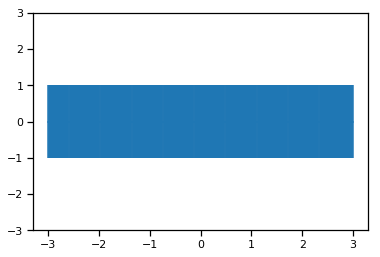

In [5]:
θ = [1, 10]
σ_0 = exponential_cov(0, 0, θ)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=σ_0, capsize=0)
plt.ylim(-3, 3);

Let's select an arbitrary starting point to sample, say $x=1$. Since there are no prevous points, we can sample from an unconditional Gaussian:

In [6]:
x = [1.]
y = [np.random.normal(scale=σ_0)]
y

[0.4967141530112327]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [7]:
σ_1 = exponential_cov(x, x, θ)

In [8]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [9]:
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, θ, σ_1, y) for i in x_pred]

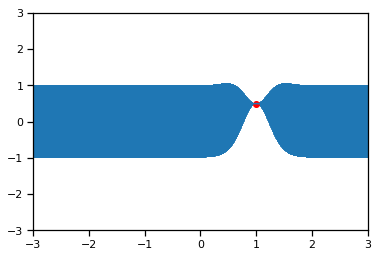

In [10]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

So conditional on this point, and the covariance structure we have specified, we have essentially constrained the probable location of additional points. Let's now sample another:

In [11]:
m, s = conditional([-0.7], x, y, θ)
y2 = np.random.normal(m, s)
y2

-0.1382640378102619

This point is added to the realization, and can be used to further update the location of the next point.

In [12]:
x.append(-0.7)
y.append(y2)

In [13]:
σ_2 = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_2, y) for i in x_pred]

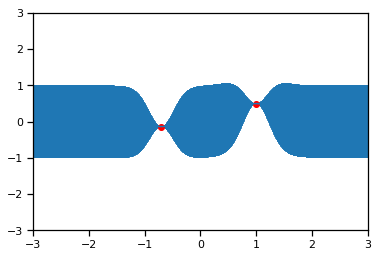

In [14]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3); plt.ylim(-3, 3);

Of course, sampling sequentially is just a heuristic to demonstrate how the covariance structure works. We can just as easily sample several points at once:

In [15]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, θ)
y_more = np.random.multivariate_normal(mu, s)
y_more

array([-1.5128756 ,  0.52371713, -0.13952425, -0.93665367, -1.29343995])

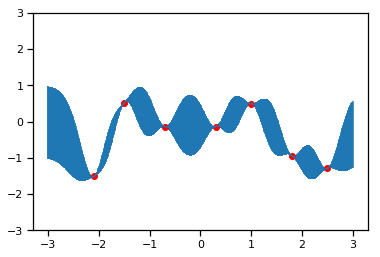

In [16]:
x += x_more
y += y_more.tolist()

σ_new = exponential_cov(x, x, θ)

predictions = [predict(i, x, exponential_cov, θ, σ_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3);

So as the density of points becomes high, the result will be one realization (function) from the prior GP. 

This example, of course, is trivial because it is simply a random function drawn from the prior. What we are really interested in is *learning* about an underlying function from information residing in our data. In a parametric setting, we either specify a likelihood, which we then maximize with respect to the parameters, of a full probability model, for which we calculate the posterior in a Bayesian context. Though the integrals associated with posterior distributions are typically intractable for parametric models, they do not pose a problem with Gaussian processes.

## Gaussian processes regression

The following simulated data clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

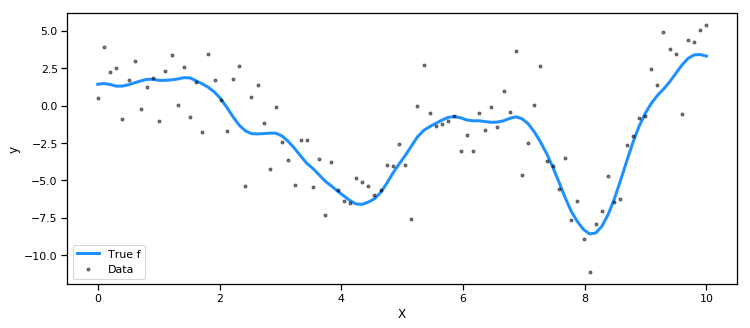

In [17]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
x = np.linspace(0, 10, n)
X = x[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

## Marginal Likelihood Implementation

The `gp.Marginal` class in PyMC3 implements the simplest case of GP regression:  the observed data are the sum of a GP and Gaussian noise.  `gp.Marginal` has a `marginal_likelihood` method, a `conditional` method, and a `predict` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

The observations $y$ are the unknown function plus noise

$$
\begin{aligned}
  \epsilon &\sim N(0, \Sigma) \\
  y &= f(x) + \epsilon \\
\end{aligned}
$$

### The Marginal Likelihood

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

$$p(y|X) = \int_f p(y|f,X)p(f|X) df$$

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

**GP prior**:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

**Gaussian likelihood**:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

**Marginal likelihood**:

$$\log p(y|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginal likelihood.

### Covariance functions

The behavior of individual realizations from the GP is governed by the covariance function. This function controls both the degree of *shrinkage* to the mean function and the *smoothness* of functions sampled from the GP.

PyMC3 includes a library of covariance functions to choose from. A flexible choice to start with is the Mat&#232;rn covariance. 

$$k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)$$

where where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* **amplitude** ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Mat&#232;rn function (*i.e.* set to one)

* **lengthscale** ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values make points appear closer together.

* **roughness** ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in \{3/2, 5/2\}$ are extremely common.

To provide an idea regarding the variety of forms or covariance functions, here's small selection of available ones:

In [18]:
X = np.linspace(0,2,200)[:,None]

# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    with sns.axes_style("white"):

        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        m = ax1.imshow(K, cmap="inferno", 
                       interpolation='none', 
                       extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
        plt.colorbar(m);
        ax1.set_title("Covariance Matrix")
        ax1.set_xlabel("X")
        ax1.set_ylabel("X")

        ax2 = fig.add_subplot(122)
        if not stationary:
            ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
            ax2.set_title("The Diagonal of K")
            ax2.set_ylabel("k(x,x)")
        else:
            ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
            ax2.set_title("K as a function of x - x'")
            ax2.set_ylabel("k(x,x')")
        ax2.set_xlabel("X")

        fig = plt.figure(figsize=(14,4))
        ax = fig.add_subplot(111)
        samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
        for i in range(samples.shape[1]):
            ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
        ax.set_title("Samples from GP Prior")
        ax.set_xlabel("X")

### Quadratic exponential covariance

This is the squared exponential covariance function.

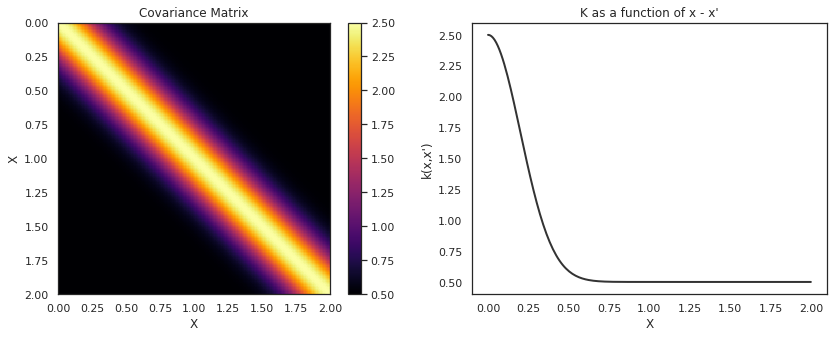

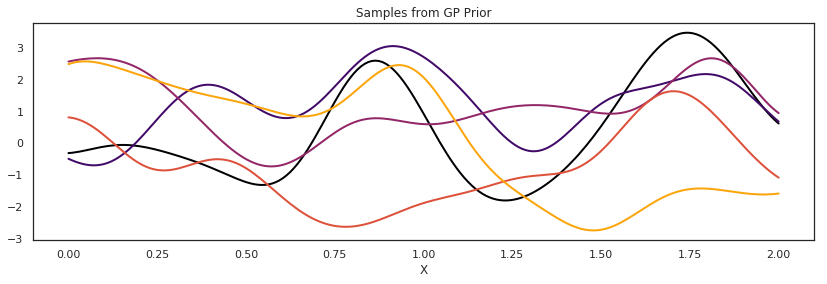

In [19]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = theano.function([], cov(X))()

plot_cov(X, K)

### Matern $\nu=3/2$ covariance

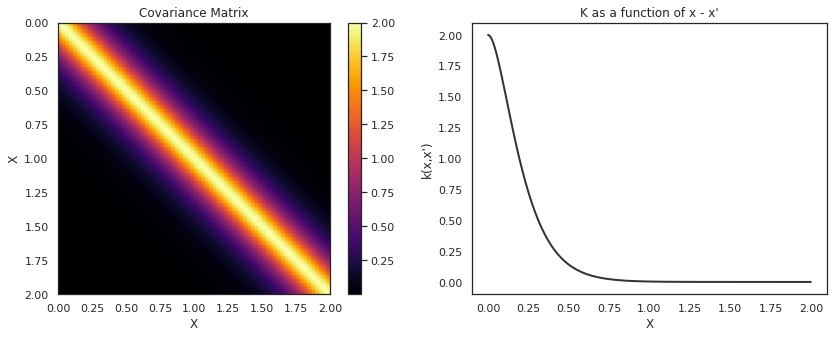

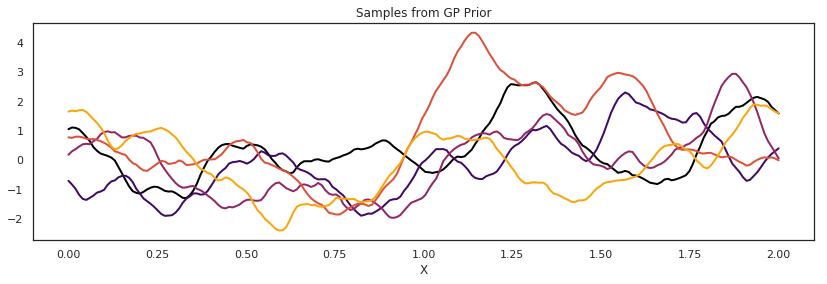

In [20]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1, l)

K = theano.function([], cov(X))()

plot_cov(X, K)

### Cosine covariance

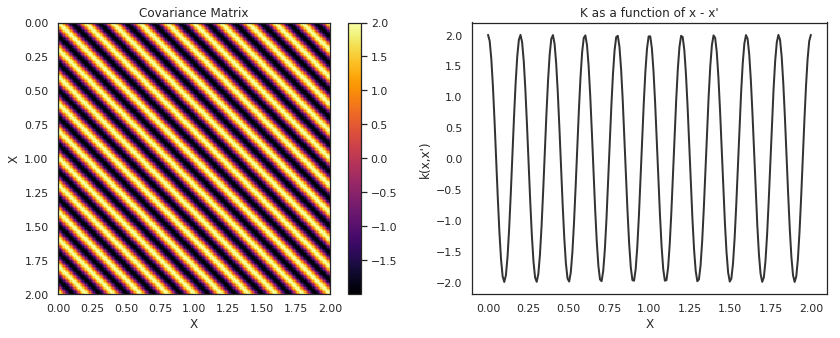

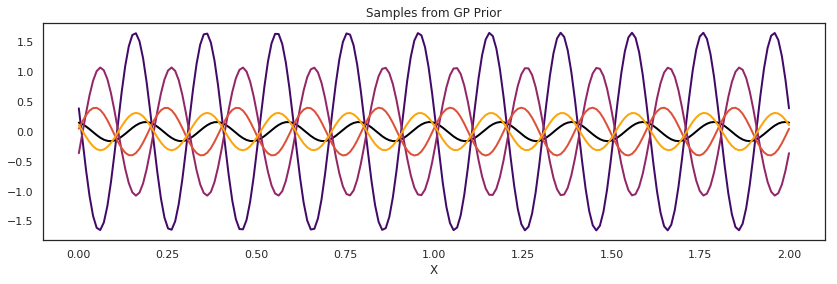

In [21]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = theano.function([], cov(X))()

plot_cov(X, K)

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

We can use a Matern(5/2) covariance to model our simulated data, and pass this as the `cov_func` argument to the `Marginal` class.

In [22]:
with pm.Model() as model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    mean = pm.gp.mean.Constant(c=1)
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)

### The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.

In [24]:
X = x.reshape(-1, 1)

with model:
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, y=y, noise=σ)

In [25]:
with model:
    marginal_post = pm.find_MAP()

logp = -232.1, ||grad|| = 0.00037013: 100%|██████████| 12/12 [00:00<00:00, 175.32it/s]  


We can collect the results into a pandas dataframe to display

In [26]:
pd.DataFrame({"Parameter": ["ℓ", "η", "σ"], 
              "Value at MAP": [float(marginal_post["ℓ"]), float(marginal_post["η"]), float(marginal_post["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

,Parameter,Value at MAP,True value
0,ℓ,1.071717,1.0
1,η,3.774687,3.0
2,σ,1.903994,2.0


### The `.conditional` distribution

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC3 allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `conditional` method implements the predictive GP above, called with a grid of points over which to generate realizations:

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  

If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  

We can define a grid of new values from `x=0` to `x=20`, then add the GP conditional to the model, given the new X values:



In [27]:
X_new = np.linspace(0, 20, 600)[:,None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

We can draw samples from the posterior predictive distribution over the specified grid of values.

In [30]:
with model:
    pred_samples = pm.sample_ppc([marginal_post], vars=[f_pred], samples=500)

100%|██████████| 500/500 [01:45<00:00,  4.75it/s]


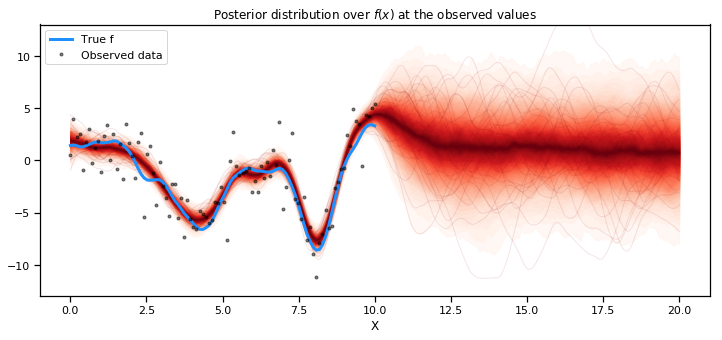

In [31]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [34]:
with model:
    #y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_ppc([marginal_post], vars=[y_pred], samples=500)

100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


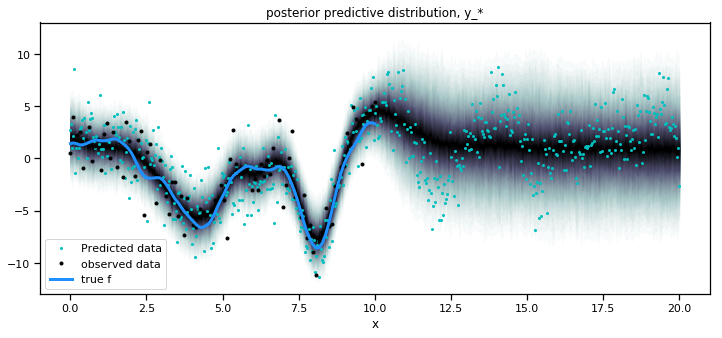

In [35]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the 
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][200, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

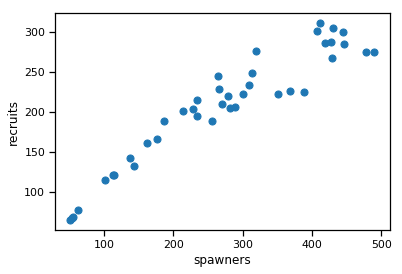

In [36]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [47]:
with pm.Model() as salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 3)
    η = pm.HalfCauchy('η', 3)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 1)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)
    

In [38]:
with salmon_model:
    salmon_trace = pm.sample(1000, tune=3000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, η, ρ]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:55<00:00, 145.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


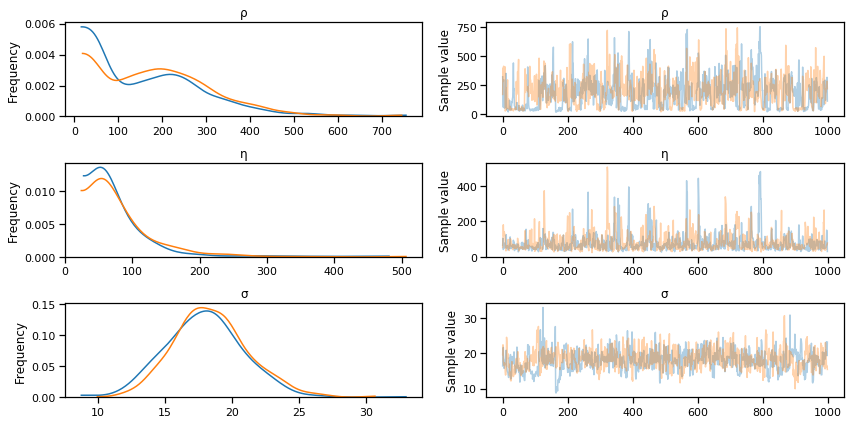

In [39]:
pm.traceplot(salmon_trace, varnames=['ρ', 'η', 'σ']);

In [40]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_ppc(salmon_trace, vars=[salmon_pred], samples=3, random_seed=42)

100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


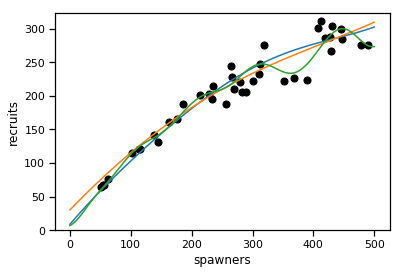

In [41]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in salmon_samples['salmon_pred']:
    ax.plot(X_pred, x);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution (via `conditional`) that covers this range of spawners.

In [48]:
# Write answer here

X_pred = np.linspace(0, 800, 100).reshape(-1, 1)
with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_ppc(salmon_trace, vars=[salmon_pred], samples=10, random_seed=42)

100%|██████████| 10/10 [00:00<00:00, 16.71it/s]


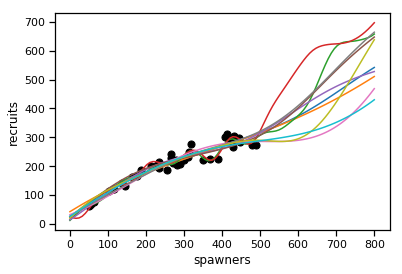

In [49]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
#ax.set_ylim(0, None)
for x in salmon_samples['salmon_pred']:
    ax.plot(X_pred, x);

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

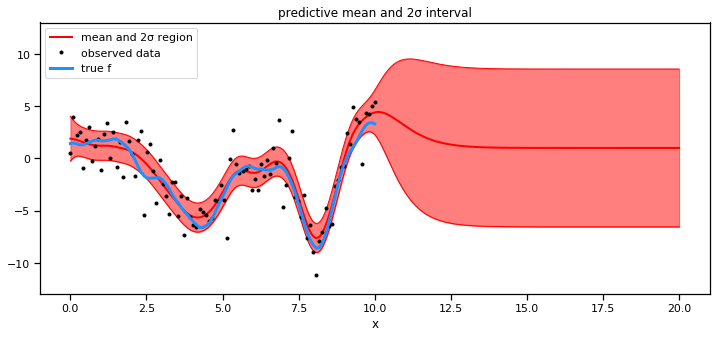

In [50]:
# predict
mu, var = gp.predict(X_new, point=marginal_post, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

## Latent Variable Implementation

The `gp.Latent` class is a more general implementation of a GP.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method, and a `conditional` method.  Given a mean and covariance function, the function $f(x)$ is modeled as,

$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$

## `.prior`

With some data set of finite size, the `prior` method places a multivariate normal prior distribution on the vector of function values, $\mathbf{f}$,

$$
\mathbf{f} \sim \text{MvNormal}(\mathbf{m}_{x},\, \mathbf{K}_{xx}) \,,
$$

where the vector $\mathbf{m}$ and the matrix $\mathbf{K}_{xx}$ are the mean vector and covariance matrix evaluated over the inputs $x$.  

By default, PyMC3 reparameterizes the prior on `f` under the hood by rotating it with the Cholesky factor of its covariance matrix.  This helps to reduce covariances in the posterior of the transformed random variable, `v`.  The reparameterized model is,

$$
\begin{aligned}
  \mathbf{v} \sim \text{N}(0, 1)& \\
  \mathbf{L} = \text{Cholesky}(\mathbf{K}_{xx})& \\
  \mathbf{f} = \mathbf{m}_{x} + \mathbf{Lv} \\
\end{aligned}
$$

This reparameterization can be disabled by setting the optional flag in the `prior` method, `reparameterize = False`.  The default is `True`.

## Robust regession

The following is an example showing how to specify a simple model with a GP prior using the `gp.Latent` class.  So we can verify that the inference we perform is correct, the data set is made using a draw from a GP.  This will be identical to the first example, except that the noise is Student-T distributed.

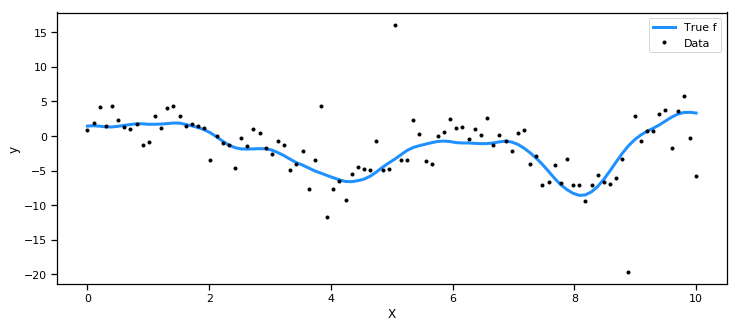

In [51]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

Here's the model in PyMC3.  We use a $\text{Gamma}(2, 1)$ prior over the lengthscale parameter, and weakly informative $\text{HalfCauchy}(5)$ priors over the covariance function scale, and noise scale.  A $\text{Gamma}(2, 0.1)$ prior is assigned to the degrees of freedom parameter of the noise.  Finally, a GP prior is placed on the unknown function.  

In [52]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)
    
    trace = pm.sample(1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, f_rotated_, η, ℓ]
Sampling 2 chains: 100%|██████████| 3000/3000 [02:52<00:00, 14.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


Below are the posteriors of the covariance function hyperparameters.  The red lines show the true values that were used to draw the function from the GP.

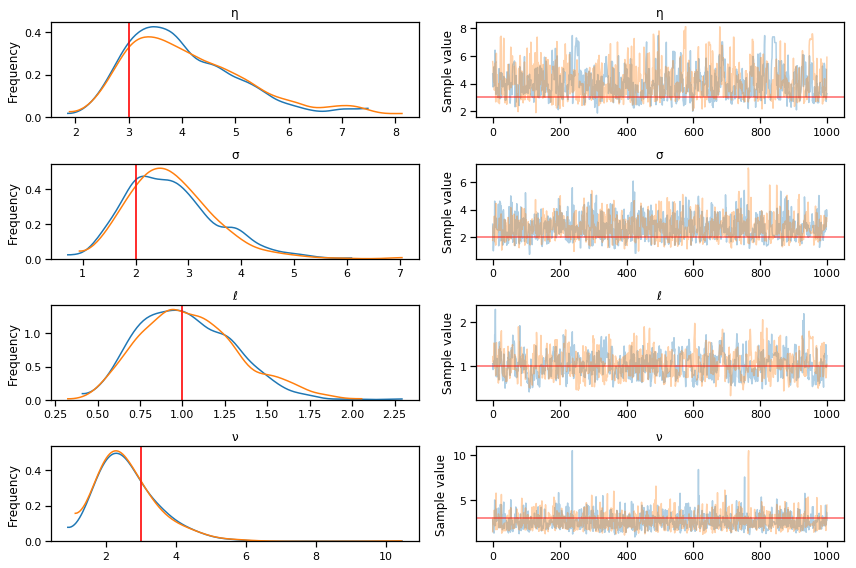

In [53]:
pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true, "ν": ν_true}, varnames=["η", "σ", "ℓ", "ν"]);

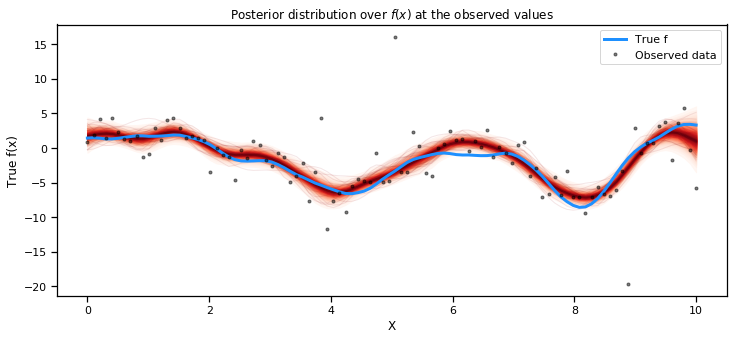

In [54]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

## Faster Gaussian processes

One of the major constraints that limits the utility of Gaussian processes in practice is the inversion of $K$ when calculating the posterior covariance. Since it is evaluated at every observed data point, its execution time is $\mathcal{O(n^3)}$, which makes Gaussian processes (in the form I have presented here) impractical for larger datasets.

An approach for dealing with this computation complexity is to look for an approximation to accelerate training and prediction. For Gaussian processes, this can be accomplished by employing a **sparse approximation** to the Gram matrix that places $M<<N$ *inducing points* along the range of the input variables, and uses this to estimate the full covariance matrix for the observed points. 

The `gp.MarginalSparse` class implements sparse, or inducing point, GP approximations.  It works identically to `gp.Marginal`, except it additionally requires the locations of the inducing points (denoted `Xu`), and it accepts the argument `sigma` instead of `noise` because these sparse approximations assume white IID noise.

The downside of sparse approximations is that they reduce the expressiveness of the GP.  Reducing the dimension of the covariance matrix effectively reduces the number of covariance matrix eigenvectors that can be used to fit the data.  

A choice that needs to be made is where to place the inducing points.  One option is to use a subset of the inputs.  Another possibility is to use K-means.  The location of the inducing points can also be an unknown and optimized as part of the model.  These sparse approximations are useful for speeding up calculations when the density of data points is high and the lengthscales is larger than the separations between inducing points. 

### Dense dataset

For the following examples, we use the same data set as was used in the `gp.Marginal` example, but with more data points.

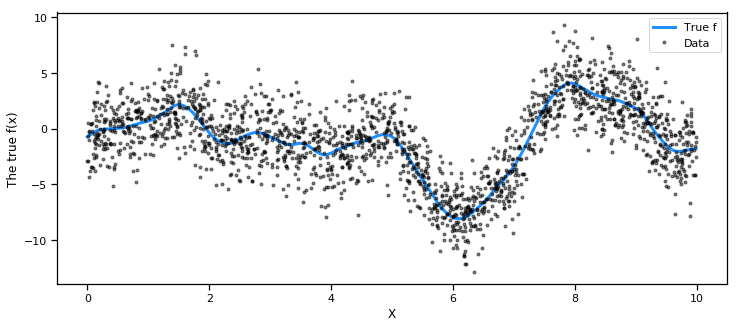

In [55]:
# set the seed
np.random.seed(1)

n = 2000 # The number of data points
X = 10*np.sort(np.random.rand(n))[:,None]

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

We can specify a sparse marginal likelihood model via `MarginalSparse`, where the approximation method can be chosen. We will use the **fully independent training conditional (FITC)** algorithm to estimate the model, with the critical approximation being the imposition of a conditional independence assumption on the joint prior over training and test cases.

In [56]:
with pm.Model() as sparse_model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

We next need a set of inducing points. We will initialize 20 inducing points with the **K-means** algorithm.

In [57]:
with sparse_model:
    
    Xu = pm.gp.util.kmeans_inducing_points(20, X)

From here, we use the `marginal_likelihood` method, just as we did with the full GP.

In [58]:
with sparse_model:
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, Xu=Xu, y=y, noise=σ)
    
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [σ, η, ℓ]
100%|██████████| 1500/1500 [00:58<00:00, 25.52it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8836346665966489, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [59]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with sparse_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with sparse_model:
    pred_samples = pm.sample_ppc(trace, vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [01:14<00:00, 13.40it/s]


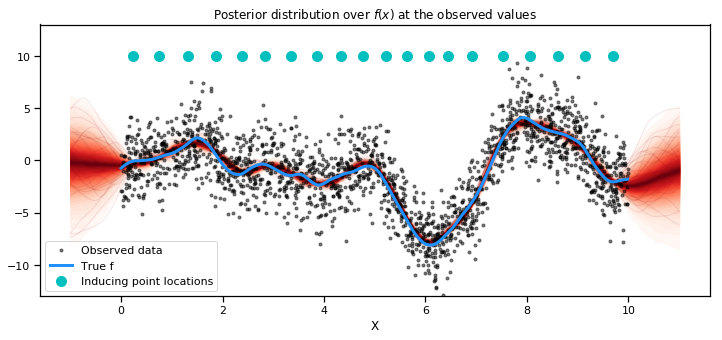

In [60]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

### Multidimensional GP

Until now, our examples have been of 1-dimensional Gaussian processes, where there is just a single predictor variable thought to have a non-linear relationship to the outcome. Let's look at a real-world dataset that involves two predictors. We will use the famous **Walker Lake dataset (Isaaks & Srivistava 1989)** that involves spatial sampling of minerals and other variables over space. The data consist of two spatial coordinates and three measured outcomes. The outcomes are anonymously labeled as U, V (continuous variables, such as concentrarion) and T (discrete variable, such as the presence of a particular element). 

In [61]:
walker_data = pd.read_table('../data/walker.txt', sep='\s+', index_col=0, skiprows=8, header=None, 
              names=['ID', 'Xloc', 'Yloc', 'V', 'U', 'T'])
walker_data.head()

,Xloc,Yloc,V,U,T
ID,,,,,
1,11,8,0.0,1.000000e+31,2
2,8,30,0.0,1.000000e+31,2
3,9,48,224.4,1.000000e+31,2
4,8,69,434.4,1.000000e+31,2
5,9,90,412.1,1.000000e+31,2


The samples are taken regularly over a coarse grid across the entire area, and then irregularly over portions of the area, presumably where there were positive samples on the coarser grid. 

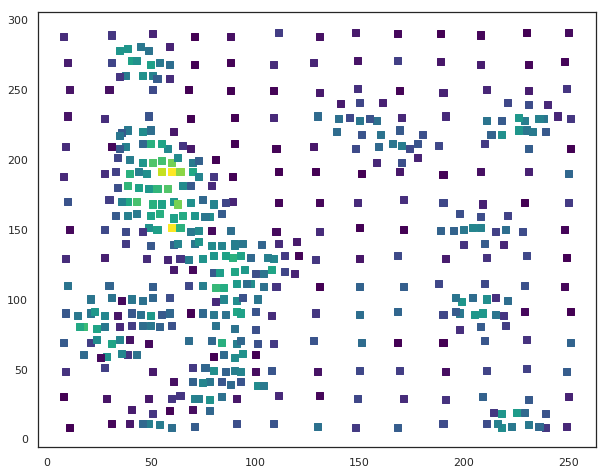

In [62]:
nx = 40
x1, x2 = np.meshgrid(np.linspace(0,300,nx), np.linspace(0,300,nx))
X = np.concatenate([x1.reshape(nx*nx, 1), x2.reshape(nx*nx, 1)], 1)

X_obs = walker_data[['Xloc', 'Yloc']].values
y_obs = walker_data.V.values

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(X_obs[:,0], X_obs[:,1], s=50, c=y_obs, marker='s', cmap=plt.cm.viridis);

We need a grid to predict on, as well as a sparser grid of inducing points:

In [63]:
nd = 30
z1, z2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

nd = 15
xu1, xu2 = np.meshgrid(np.linspace(0, 300, nd), np.linspace(0, 300, nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [64]:
with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", beta=3, shape=(2,))
    sf2 = pm.HalfCauchy("sf2", beta=3)
    sn2 = pm.HalfCauchy("sn2", beta=3)

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=sn2)

    mp = pm.find_MAP()

logp = -3,304.5, ||grad|| = 0.037952: 100%|██████████| 45/45 [00:01<00:00, 25.70it/s]      


In [65]:
with spatial_model:

    f_pred = gp_spatial.conditional('f_pred', Z)
    
    samples = pm.sample_ppc([mp], vars=[f_pred], samples=100)

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


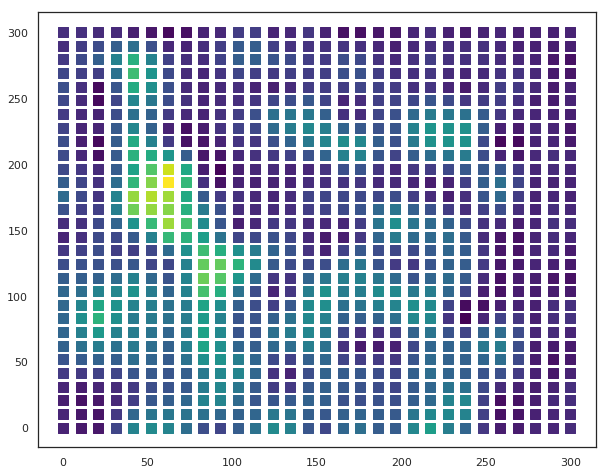

In [66]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    plt.scatter(z1.flatten(), z2.flatten(), s=100, c=samples['f_pred'].mean(0), marker='s', cmap=plt.cm.viridis);

## Example: Nashville daily temperatures

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Use a Gaussian process to fit a regression model to this data.

In [67]:
daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

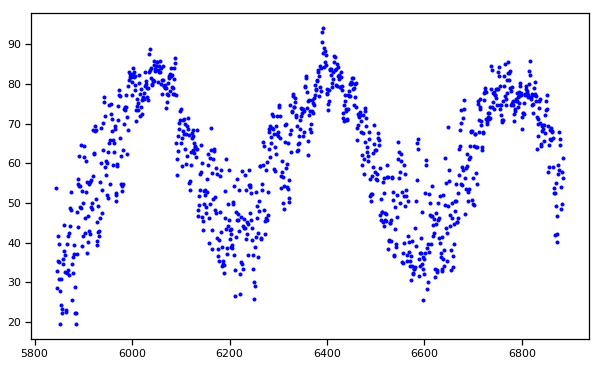

In [68]:
temps_2010 = daily_temps.temp[daily_temps.year>2010]
temps_2010.plot(style='b.', figsize=(10,6), grid=False)

In [69]:
x, y = temps_2010.reset_index().values.T
X = x.reshape(-1, 1)

In [93]:
with pm.Model() as temp:
    
    l = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    m = pm.gp.mean.Constant(temps_2010.mean())
    cov = η**2 * pm.gp.cov.Matern52(1, l)
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")
    
    Xu = pm.gp.util.kmeans_inducing_points(15, X)
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, Xu=Xu, y=y, noise=σ)

In [94]:
with temp:
    trace = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [σ, η, ℓ]
100%|██████████| 1500/1500 [00:29<00:00, 50.69it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [95]:
X_new = np.linspace(-1, 11, 200)[:,None]

# add the GP conditional to the model, given the new X values
with temp:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with temp:
    pred_samples = pm.sample_ppc(trace, vars=[f_pred], samples=100)

100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


ValueError: x and y must have same first dimension, but have shapes (1042, 1) and (2000,)

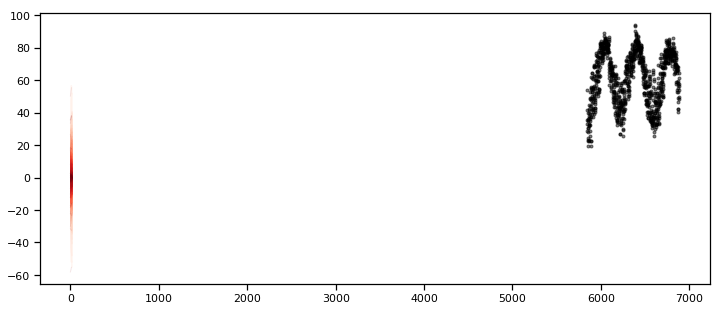

In [98]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

## References

[Rasmussen, C. E., & Williams, C. K. I. (2005). Gaussian Processes for Machine Learning (Adaptive Computation and Machine Learning series). The MIT Press.](http://www.amazon.com/books/dp/026218253X)

[Quinonero-Candela, J. & Rasmussen, C. E. (2005). A Unifying View of Sparse Approximate Gaussian Process Regression
Journal of Machine Learning Research 6, 1939–1959.](http://www.jmlr.org/papers/v6/quinonero-candela05a.html)

